In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<Figure size 1200x600 with 0 Axes>

In [78]:
df = pd.read_csv('../../data_cleaned/merged/all_data_2018_2025_da.csv')
df.head()

,price,c_by_hour,load_forecast_da,off_wind_da,on_wind_da,solar_da,gen_forecast_da,res_sum_da,date,year,month,day,weekday,hour,dayofyear,is_holiday,day_type
0,28.32,4,43647.5450,5068.9000,18879.7900,0.0,51070.88,23948.6900,2019-01-01,2019,1,1,1,0,1,1,holiday
1,10.07,4,41692.5650,5042.4425,20626.5625,0.0,51084.26,25669.0050,2019-01-01,2019,1,1,1,1,1,1,holiday
2,-4.08,4,40587.2325,5028.4175,22355.6850,0.0,51512.67,27384.1025,2019-01-01,2019,1,1,1,2,1,1,holiday
3,-9.91,4,40308.2500,4977.6500,24032.4775,0.0,52693.45,29010.1275,2019-01-01,2019,1,1,1,3,1,1,holiday
4,-7.41,4,40659.5750,4907.4000,25452.1675,0.0,53666.46,30359.5675,2019-01-01,2019,1,1,1,4,1,1,holiday


In [79]:
df['date']= pd.to_datetime(df['date'])
df_2021 = df[df['date'].dt.year == 2021]
df = df.query('year < 2021')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17544 entries, 0 to 17543
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   price             17544 non-null  float64       
 1   c_by_hour         17544 non-null  int64         
 2   load_forecast_da  17544 non-null  float64       
 3   off_wind_da       17544 non-null  float64       
 4   on_wind_da        17544 non-null  float64       
 5   solar_da          17544 non-null  float64       
 6   gen_forecast_da   17544 non-null  float64       
 7   res_sum_da        17544 non-null  float64       
 8   date              17544 non-null  datetime64[ns]
 9   year              17544 non-null  int64         
 10  month             17544 non-null  int64         
 11  day               17544 non-null  int64         
 12  weekday           17544 non-null  int64         
 13  hour              17544 non-null  int64         
 14  dayofyear         17544 non

### Adding Residual_load feature which is a difference of load_forecast_da and res_sum_da


In [80]:
df['residual_load']= df['load_forecast_da'] - df['res_sum_da']

### Creating daily data by taking average price (target) and other exogeneous  variables and then setting date as index

In [81]:
daily_data_df = df.groupby(['date', 'year', 'month', 'day', 'dayofyear'], as_index=False).agg(
    {'price': np.mean, 
     'is_holiday': max, 
     'residual_load': np.mean
     }).set_index('date')
daily_data_df.head()

,year,month,day,dayofyear,price,is_holiday,residual_load
date,,,,,,,
2019-01-01,2019,1,1,1,-3.294583,1,12300.286771
2019-01-02,2019,1,2,2,26.099583,0,25254.939896
2019-01-03,2019,1,3,3,57.872083,0,43635.007604
2019-01-04,2019,1,4,4,50.432917,0,33629.132396
2019-01-05,2019,1,5,5,42.240000,0,28340.210729


### Function to smoothen the data by rolling with window size

In [82]:
def smoothen_data(df,window_size):
    return df.rolling(window=window_size, center=True).mean().dropna()


### Here called smoothen function with window_size
if window_size =1 then it consider original daily data otherwise it can be rolled by 7 day, 30 days or x-days

In [91]:
data = smoothen_data(daily_data_df,1)

### Plotting to see how changing window_size can smoothen data

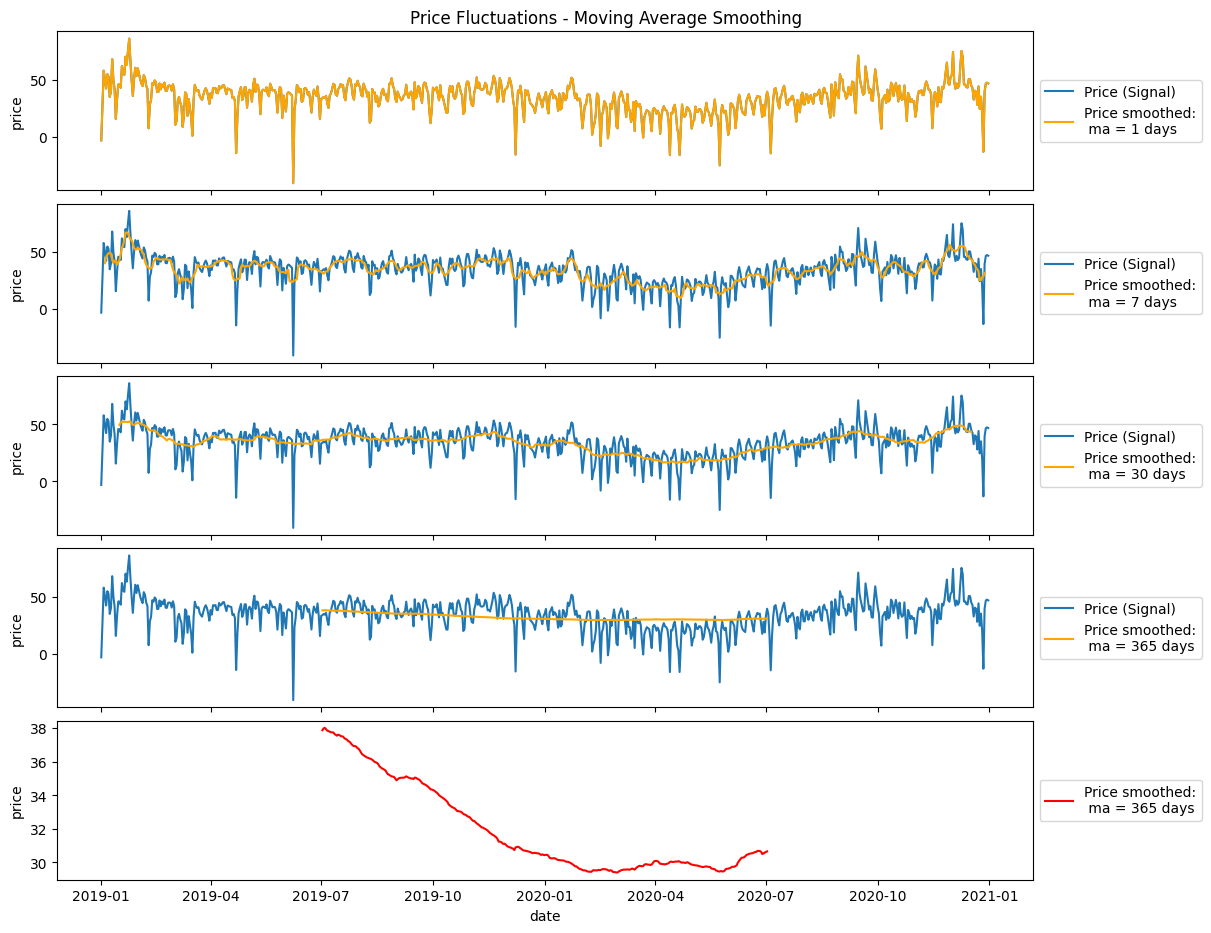

In [92]:
ma = [1,7, 30,365]

smooth_daily_data_df = daily_data_df.reset_index().assign(date = lambda x: x['date'].transform(pd.to_datetime))

# Smooth and plot
fig, ax = plt.subplots(len(ma)+1, 1, figsize=(12, 9), constrained_layout=True, sharex=True)
plt.suptitle('Price Fluctuations - Moving Average Smoothing', y=1.02);

for i, m in enumerate(ma):
    smooth_daily_data_df[f'temp_smooth_ma_{m}'] = smooth_daily_data_df['price'].rolling(window=m,center=True).mean() #compute the rolling mean

    sns.lineplot(x='date', y='price', label='Price (Signal)', data=smooth_daily_data_df,  ax=ax[i])
    sns.lineplot(x='date', y=f'temp_smooth_ma_{m}', label=f'Price smoothed:\n ma = {m} days', data=smooth_daily_data_df, color='orange', ax=ax[i])

    ax[i].legend(title='', loc='center left', bbox_to_anchor=(1, 0.5))
    ax[i].set(title='', ylabel='price');
        
sns.lineplot(x='date', y=f'temp_smooth_ma_{m}', label=f'Price smoothed:\n ma = {m} days', data=smooth_daily_data_df, color='red', ax=ax[i+1])
ax[i+1].legend(title='', loc='center left', bbox_to_anchor=(1, 0.5))
ax[i+1].set(title='', ylabel='price');


### Decompose data by seasonal_decompose with given period and plot it


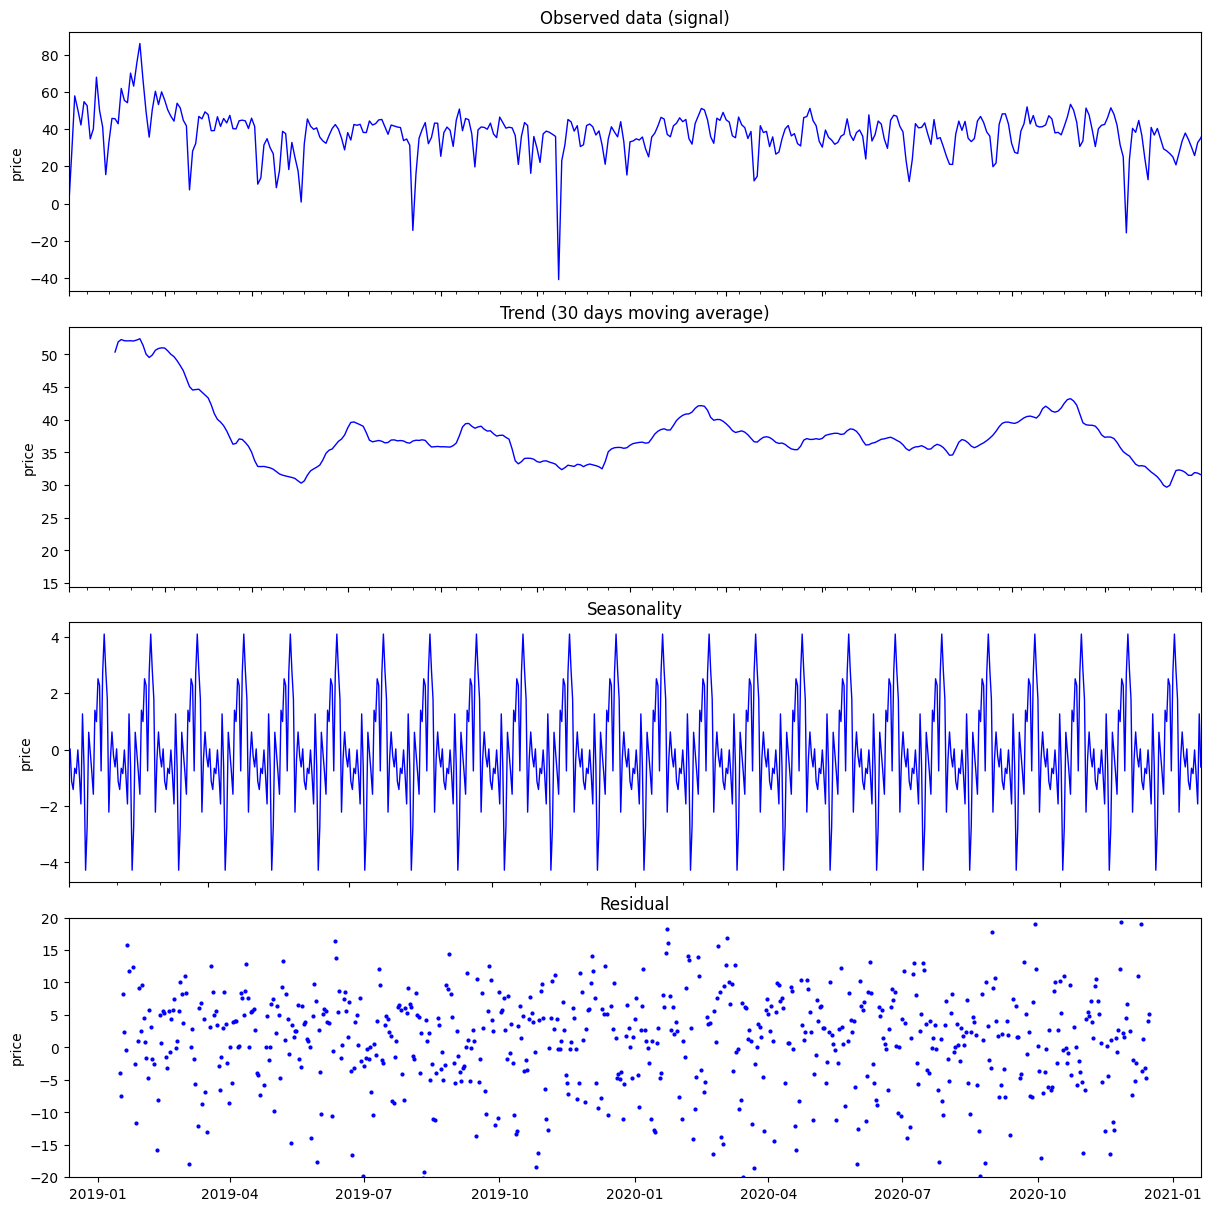

In [99]:
seas_decomp_yearly = seasonal_decompose(x=data['price'],model='additive',two_sided=True,period= 30)
fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
ax[0].set(title='Observed data (signal)',  ylabel='price')
seas_decomp_yearly.observed.plot(color='blue',linewidth=1,sharex=True,ax=ax[0])
ax[1].set(title='Trend (30 days moving average)',ylabel='price')
seas_decomp_yearly.trend.plot(color='blue',linewidth=1,sharex=True,ax=ax[1])
ax[2].set(title='Seasonality',ylabel='price')
seas_decomp_yearly.seasonal.plot(color='blue',linewidth=1,sharex=True,ax=ax[2])
ax[3].set(title='Residual',ylabel='price');
ax[3].scatter(x=seas_decomp_yearly.resid.index,y=seas_decomp_yearly.resid,color='blue',s=4)
ax[3].set_ylim(-20, 20)
for i in range(2):
    ax[i].set_xlim(pd.to_datetime("2019"),pd.to_datetime("2020"))

### Checking stationarity of decompose data (residuals only) 

In [94]:
adfuller(data['price'].dropna(), autolag='AIC')[1]<0.05

True

### Splitting decomposed_residual data into train and test sets and plot

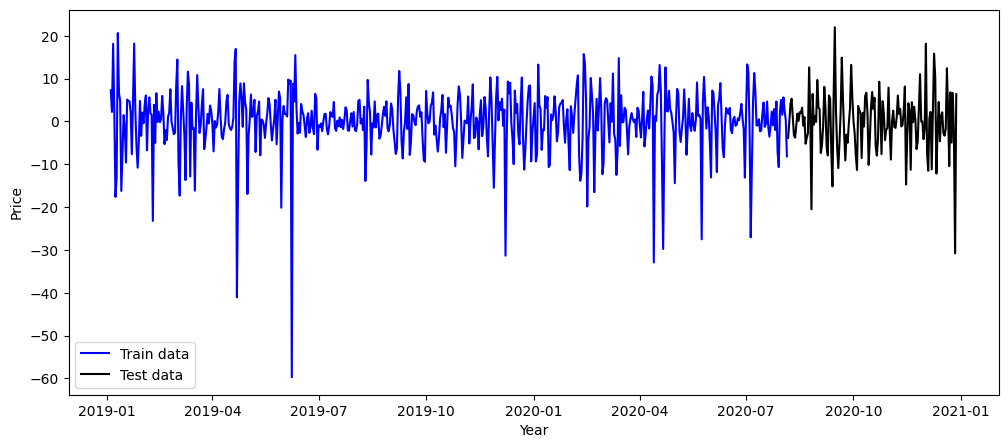

In [95]:
df_arma = seas_decomp_yearly.resid.dropna()
train_test_split_ratio = int(len(df_arma)*0.8)
train_data, test_data = df_arma[:train_test_split_ratio], df_arma[train_test_split_ratio:]

# Plotting the train and test set
plt.figure(figsize=(12,5), dpi=100)
plt.xlabel('Year')
plt.ylabel('Price')
plt.plot(train_data.index,train_data.values, 'blue', label='Train data')
plt.plot(test_data.index, test_data.values, 'black', label='Test data')
plt.legend();

### Introducing Exogeneous veriables

In [96]:
exo_var = data[['is_holiday','residual_load']].dropna().loc[df_arma.index]
exo_var

,is_holiday,residual_load
date,,
2019-01-04,0.0,33629.132396
2019-01-05,0.0,28340.210729
2019-01-06,0.0,39190.031563
2019-01-07,0.0,40181.265104
2019-01-08,0.0,20953.435208
...,...,...
2020-12-24,0.0,25078.975312
2020-12-25,1.0,33576.888333
2020-12-26,1.0,17802.180833


### Applying ARMA model (which is ARIMA by default) but taking d=0 in order and fit this model and plot its forecast on test data

/home/saadu/bootcamp_ds_ai/capstone_project/ai-for-energy/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/saadu/bootcamp_ds_ai/capstone_project/ai-for-energy/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/saadu/bootcamp_ds_ai/capstone_project/ai-for-energy/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/saadu/bootcamp_ds_ai/capstone_project/ai-for-energy/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argum

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  580
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1890.334
Date:                Thu, 12 Feb 2026   AIC                           3788.668
Time:                        13:46:42   BIC                           3806.120
Sample:                    01-04-2019   HQIC                          3795.472
                         - 08-05-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.582e-05      0.005      0.007      0.994      -0.010       0.010
ar.L1          0.4944      0.028     17.392      0.000       0.439       0.550
ma.L1         -1.0000      5.099     -0.196      0.8

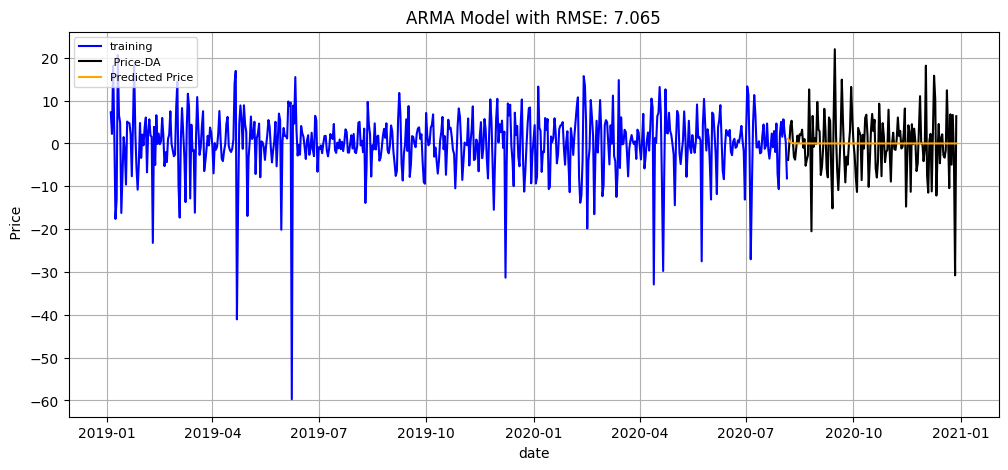

In [97]:

arma_model = ARIMA(train_data,order=(1,0,1),exog=None)
fitted_model = arma_model.fit() 
print(fitted_model.summary())
forecast_values = fitted_model.forecast(steps=len(test_data), alpha=0.05)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training', color='blue')
plt.plot(test_data, label=' Price-DA',color='black')
plt.plot(forecast_values,label='Predicted Price',color='orange')
rms_auto_arma = np.sqrt(mean_squared_error(test_data.values, forecast_values))
plt.title(f'ARMA Model with RMSE: {round(rms_auto_arma,3)}')
plt.xlabel('date')
plt.ylabel(' Price')
#plt.xticks([])
plt.legend(loc='upper left', fontsize=8)
plt.grid()
plt.show()

### Applying ARMAX model with exogeneous varibales

/home/saadu/bootcamp_ds_ai/capstone_project/ai-for-energy/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/saadu/bootcamp_ds_ai/capstone_project/ai-for-energy/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/saadu/bootcamp_ds_ai/capstone_project/ai-for-energy/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/saadu/bootcamp_ds_ai/capstone_project/ai-for-energy/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword argum

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  580
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1864.764
Date:                Thu, 12 Feb 2026   AIC                           3741.527
Time:                        13:46:42   BIC                           3767.705
Sample:                    01-04-2019   HQIC                          3751.733
                         - 08-05-2020                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -13.1729      1.047    -12.585      0.000     -15.225     -11.121
is_holiday       -6.4096      0.873     -7.343      0.000      -8.120      -4.699
residual_load     0.0004   3.19e-05     

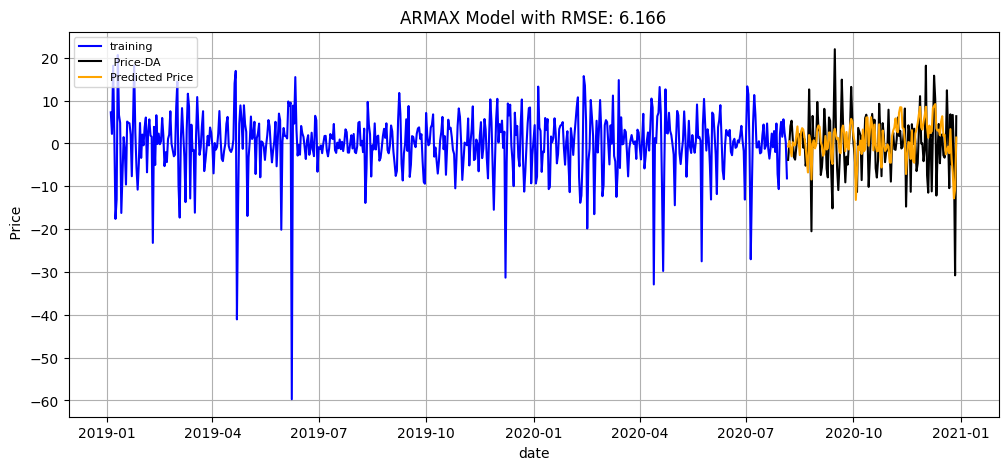

In [98]:
armaX_model = ARIMA(train_data,order=(1,0,1),exog=exo_var[:len(train_data)])
fitted_model = armaX_model.fit() 
print(fitted_model.summary())
forecast_values = fitted_model.forecast(steps=len(test_data), exog=exo_var[len(train_data):len(train_data)+len(test_data)], alpha=0.05)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training', color='blue')
plt.plot(test_data, label=' Price-DA',color='black')
plt.plot(forecast_values,label='Predicted Price',color='orange')
rms_auto_arma = np.sqrt(mean_squared_error(test_data.values, forecast_values))
plt.title(f'ARMAX Model with RMSE: {round(rms_auto_arma,3)}')
plt.xlabel('date')
plt.ylabel(' Price')
plt.legend(loc='upper left', fontsize=8)
plt.grid()
plt.show()